In [ ]:
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import numpy as np
import math
import requests
import smtplib
import ssl
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.application import MIMEApplication
from google.colab import userdata
import os

In [ ]:
def getdet():
  #Define URLs
  urls=['https://www.plastemart.com/nylon-6-PA-6/polymer-prices','https://www.plastemart.com/nylon-66-PA-66-pricelist/polymer-prices','https://www.plastemart.com/pbt-pricelist/polymer-prices']

  #Fetch the data
  for url in urls:
    try:
      resp=requests.get(url)
      res=bs(resp.text,'html.parser')
      table=res.find('table',class_='table table-responsive table-bordered')
      rows=table.find_all('tr',class_=False)
      poly_name=res.find('div',class_='btn btn-default')
      if ',' in poly_name.text:
        poly_name = poly_name.text.split(',')[1].strip()
      else:
        poly_name = poly_name.text.strip()
      months=[]
      data=[]
      for row in rows[1::]:
          cells=row.find_all('td')
          if len(months)<24:
              months.append(cells[0].text.strip())
              data.append(cells[1].text.strip())
          else:
              break
      for i in range(len(data)):
        data[i]=float(data[i].replace('$','').strip())
        data[i]=f"{round(data[i],3):.2f}"
      data=[float(val) for val in data]
      for i in range(len(months)):
        temp=months[i].split(' ')
        temp[2]=temp[2][2::]
        months[i]=' '.join(temp)
      data=data[::-1]
      months=months[::-1]
    except Exception as e:
      print('Fetch Error!')
      print(e)

    #Plot the graphs
    try:
      plt.figure(figsize=(25, 15))
      plt.plot(months, data, marker='o', linestyle='-' ,color ='orange')
      plt.title('{} PRICE TREND - 24 MONTHS'.format(poly_name.upper()), weight='bold')
      plt.xlabel('Month & year',fontsize=12)
      plt.ylabel('Values in USD/TON',fontsize=12)
      y_max = float(math.ceil(max(data))) + 1
      plt.ylim(0.00,y_max)
      plt.grid(axis='y',linestyle='-',color='gray',linewidth=0.6)
      for i,txt in enumerate(data):
          plt.annotate('$'+str(txt),(months[i],data[i]),textcoords="offset points",xytext=(0,10),ha='center')
      if(data[23]<data[22]):
        plt.annotate('', xy=(1, 0.6), xycoords='axes fraction', xytext=(1, 0.8),arrowprops=dict(facecolor='green', shrink=0.25, width=5, headwidth=10))
      else:
        plt.annotate('', xy=(1, 1), xycoords='axes fraction', xytext=(1, 0.8),arrowprops=dict(facecolor='red', shrink=0.25, width=5, headwidth=12))
      plt.savefig(f'{poly_name}.png')
    except Exception as e:
      print('Plot Error!')
      print(e)


In [ ]:
def sendmail():
    subject = "Metal Price Trends"
    sender_email = "sander@gmail.com"
    recipient_email = ['receiver1@gmail.com', 'receiver2@gmail.com']
    sender_password = 'password'
    smtp_server = 'smtp.gmail.com'
    folder_path = '/content'
    smtp_port = 465

    # Create the root message
    message = MIMEMultipart('related')
    message['Subject'] = subject
    message['From'] = sender_email
    message['To'] = ','.join(recipient_email)

    # Create the HTML body with image placeholders
    body_html = """\
    <html>
      <body>
        <p>Graph of some polymer price trends are attached below:</p>
    """

    image_list = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'rb') as attachment:
                img_data = attachment.read()
                img_cid = filename.replace(".", "_")
                body_html += f'<img src="cid:{img_cid}" width="600" height="400"><br>'
                image_list.append((img_data, img_cid, filename))
                os.remove(file_path)

    body_html += """\
      </body>
    </html>
    """

    # Attach the HTML part
    body_part = MIMEText(body_html, 'html')
    message.attach(body_part)

    # Attach the images
    for img_data, img_cid, filename in image_list:
        img_part = MIMEImage(img_data, name=filename)
        img_part.add_header('Content-ID', f'<{img_cid}>')
        img_part.add_header('Content-Disposition', 'inline', filename=filename)
        message.attach(img_part)

    # Send the email
    try:
        with smtplib.SMTP_SSL(smtp_server, smtp_port) as server:
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, recipient_email, message.as_string())
            print("Mail sent successfully!")
    except Exception as e:
        print("Mail not sent.")
        print(e)
    finally:
        print("Process completed!")
        return




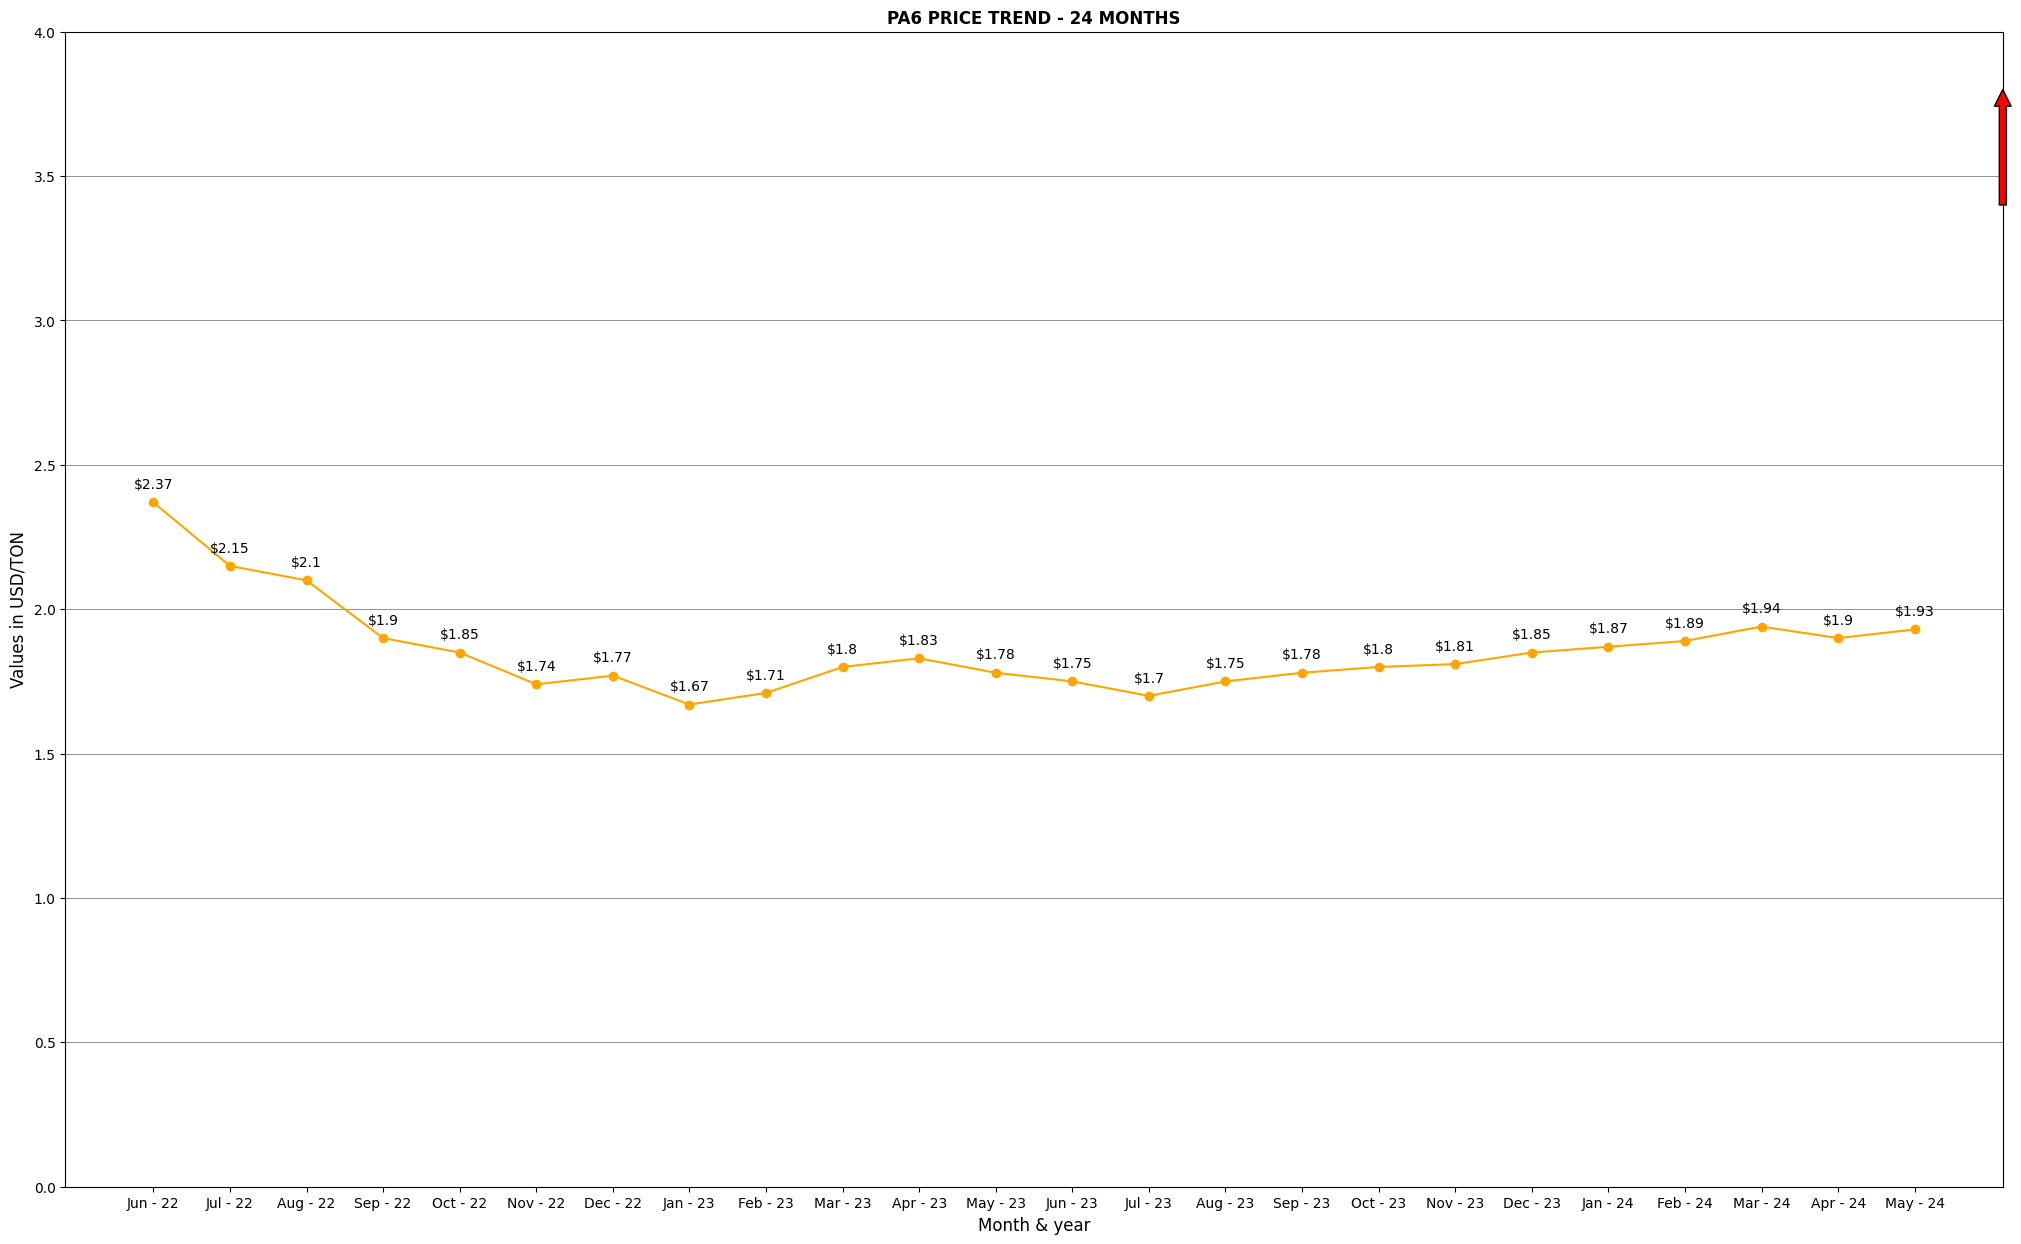

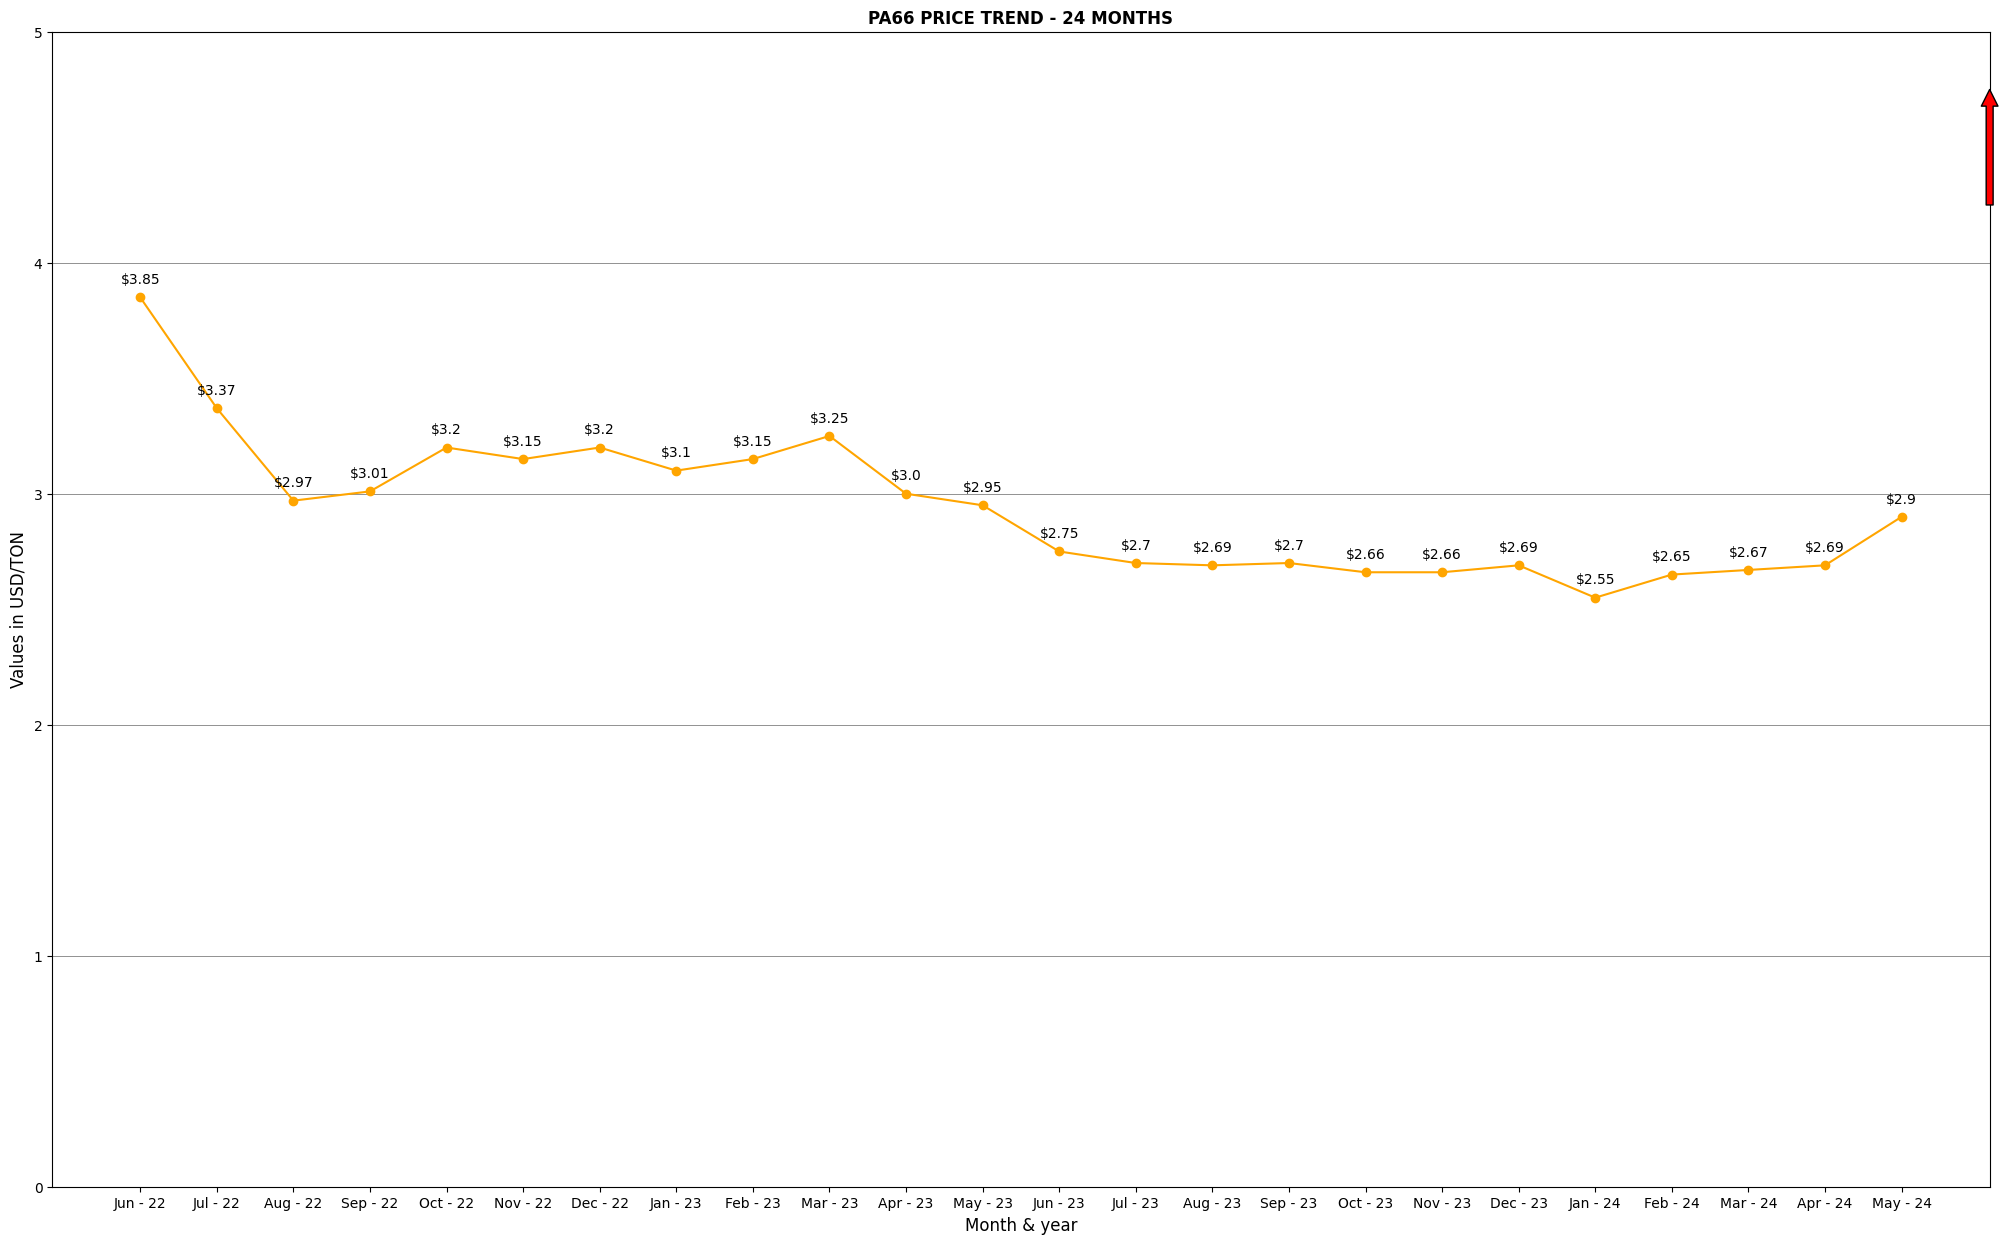

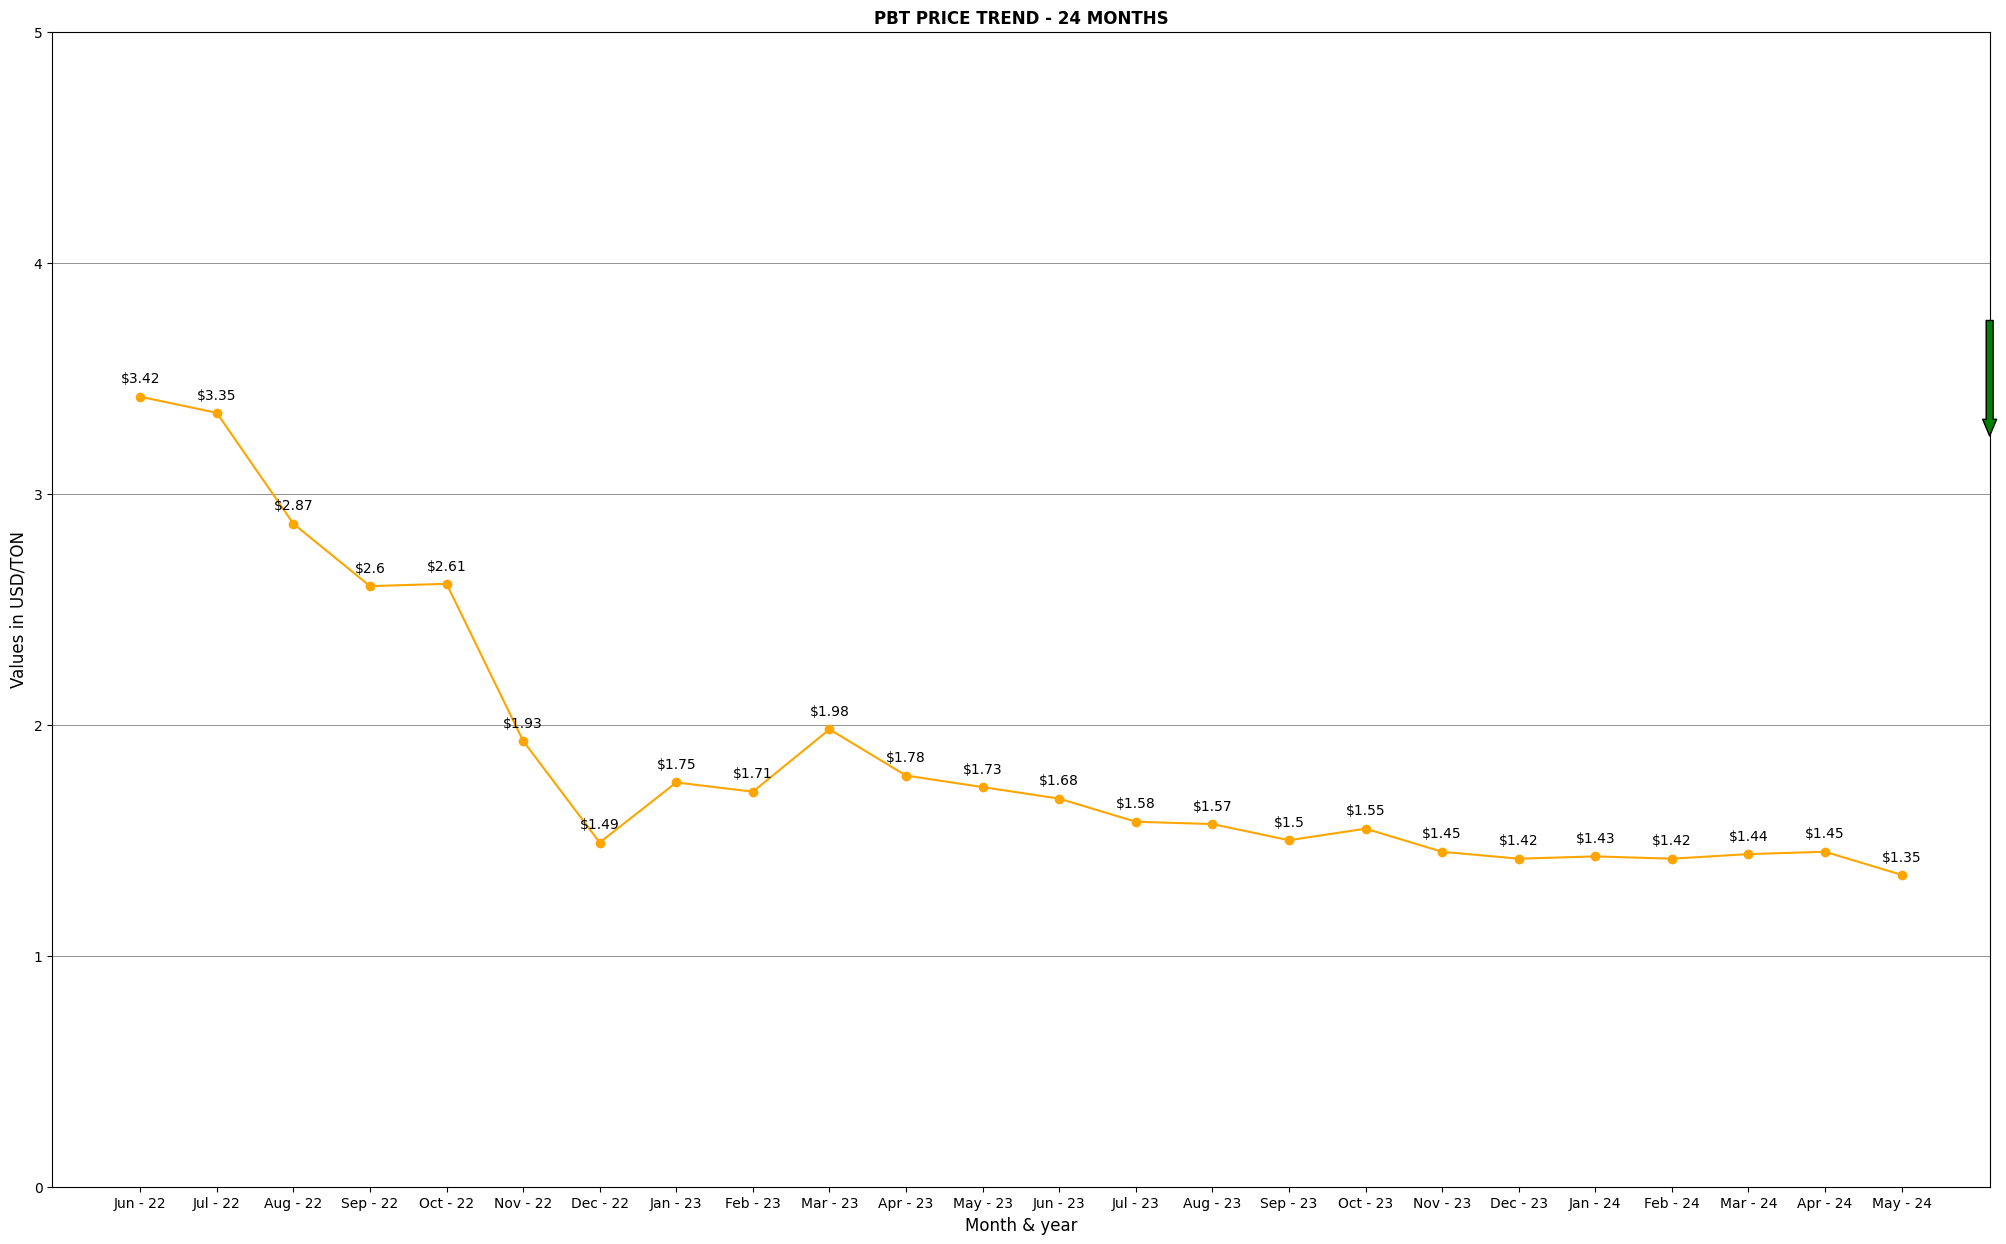

In [ ]:
def task():
  getdet()
  sendmail()
task()